In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def CNN_pred(filename):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the dataset
    df = pd.read_csv('data/'+filename+'.csv')

    # Preprocess and feature engineering
    # You may add additional features or perform feature engineering as needed
    features = df[['open', 'high', 'low', 'change', 'pct_chg', 'vol', 'amount', 'pre_close']]
    targets = df['close']

    # Convert to numpy and scale features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    targets = targets.to_numpy()

    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float32).to(device)
    targets = torch.tensor(targets, dtype=torch.float32).view(-1, 1).to(device)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.05, shuffle=False)

    # Create DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

    # CNN model
    class CNNRegressor(nn.Module):
        def __init__(self):
            super(CNNRegressor, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2, stride=1, padding='same')
            self.relu = nn.ReLU()
            self.flatten = nn.Flatten()
            self.fc1 = nn.Linear(64 * features.shape[1], 1)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add channel dimension
            x = self.conv1(x)
            x = self.relu(x)
            x = self.flatten(x)
            x = self.fc1(x)
            return x

    # Initialize model, loss function, and optimizer
    model = CNNRegressor().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        for i, (inputs, prices) in enumerate(train_loader):
            # Move tensors to the configured device
            inputs = inputs.to(device)
            prices = prices.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, prices)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

#             print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Evaluate the model
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, prices in test_loader:
            inputs = inputs.to(device)
            prices = prices.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu())
            actuals.append(prices.cpu())

    predictions = torch.cat(predictions, 0).numpy()
    actuals = torch.cat(actuals, 0).numpy()

    # Calculate metrics
    mae = mean_absolute_error(actuals, predictions)
    rmse = mean_squared_error(actuals, predictions, squared=False)
    r2 = r2_score(actuals, predictions)

    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')

    # Visualization of the predicted vs actual values
    plt.figure(figsize=(10, 5))
    plt.plot(actuals, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title(filename)
    plt.xlabel('Samples')
    plt.ylabel('Close Price')
    plt.legend()
    plt.savefig('CNN_'+filename+'.png')
#     plt.show()
    return mae, rmse, r2

C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv1d(input, weight, bias, self.stride,
C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 0.6520415544509888
RMSE: 0.8242310285568237
R^2: 0.997506537959811


C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 4.3299970626831055
RMSE: 17.330554962158203
R^2: -99.4358355269718


C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 0.7425275444984436
RMSE: 0.9807841777801514
R^2: 0.9971679555604132


C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 0.7605103254318237
RMSE: 1.125258445739746
R^2: 0.9955705457344067


C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 0.13069796562194824
RMSE: 0.16765017807483673
R^2: 0.9996410218513474


C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 13.655533790588379
RMSE: 18.13739013671875
R^2: 0.5093900897866441


C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 1.7823207378387451
RMSE: 2.546795129776001
R^2: 0.995597692456535


C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 6.556830883026123
RMSE: 9.031761169433594
R^2: 0.995252414787866


C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 5.6064043045043945
RMSE: 8.338130950927734
R^2: 0.9458528903736645


C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 0.44901347160339355
RMSE: 0.8018013834953308
R^2: 0.9940856199474933


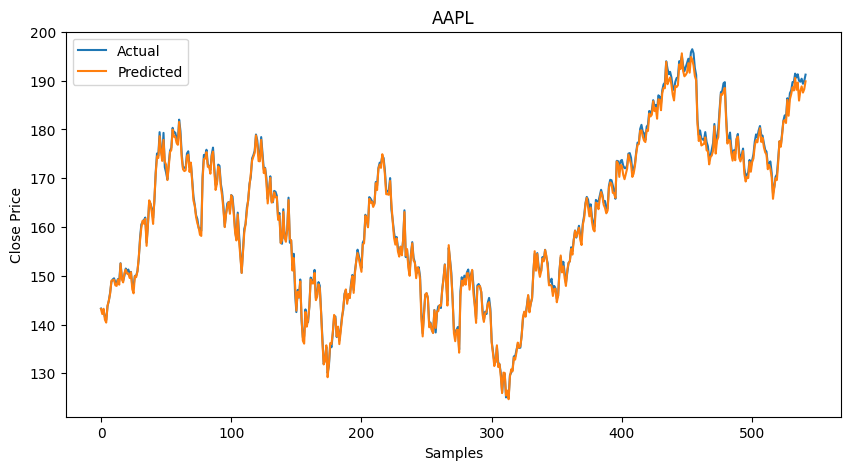

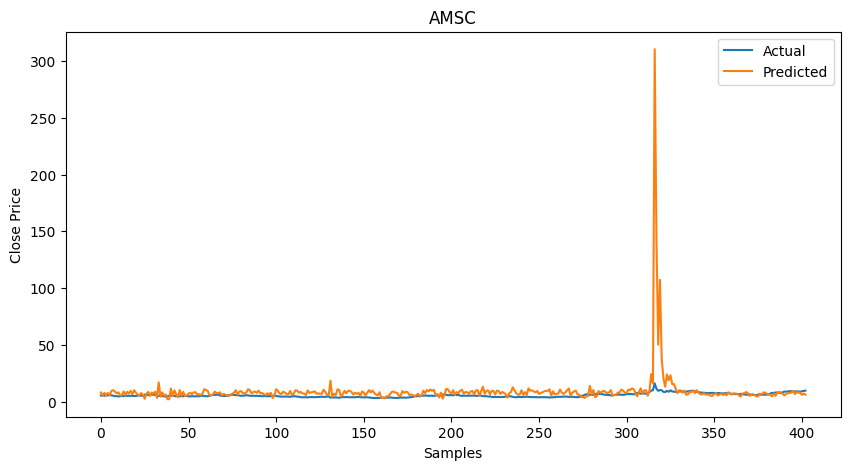

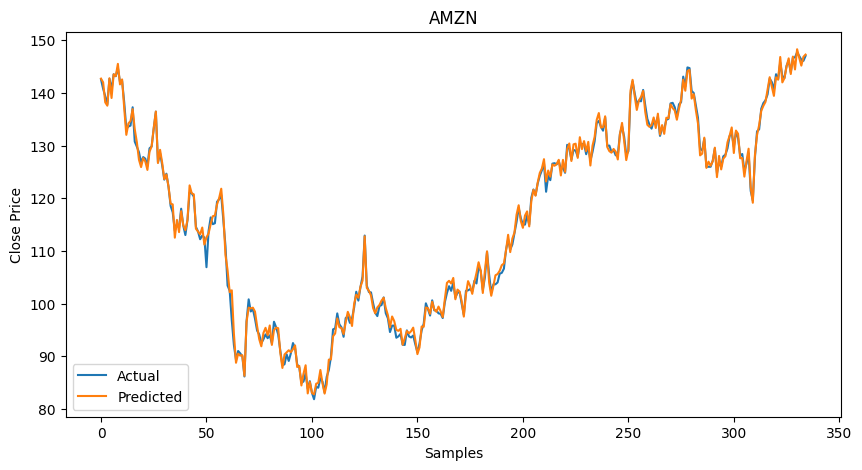

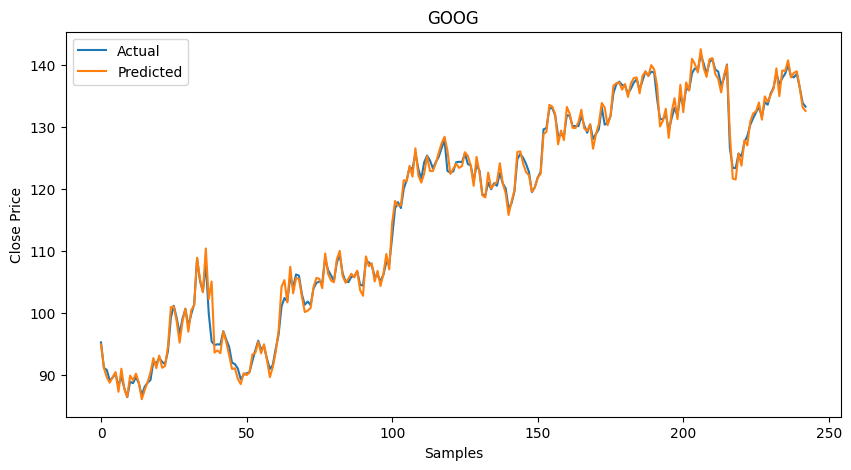

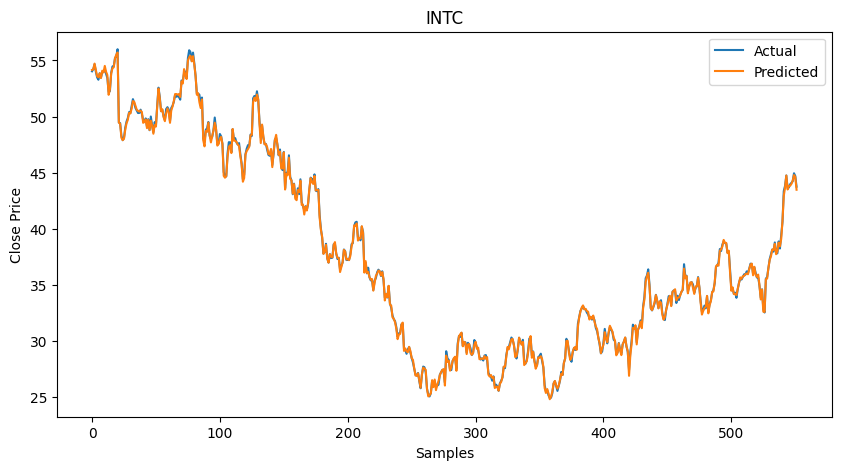

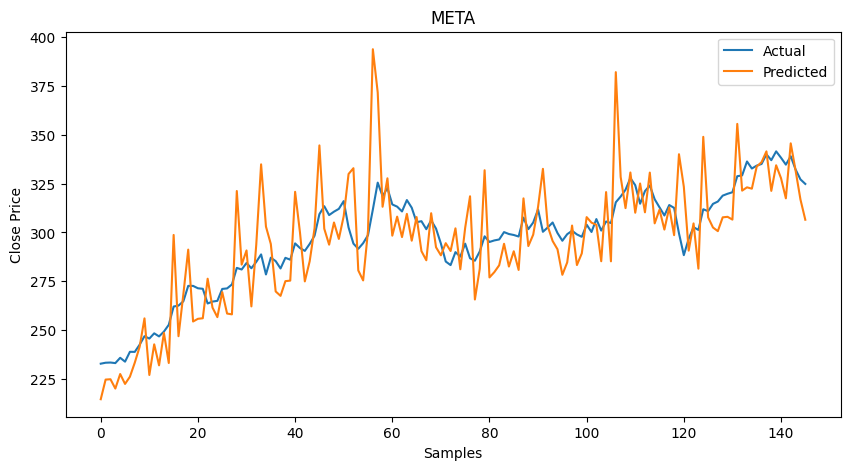

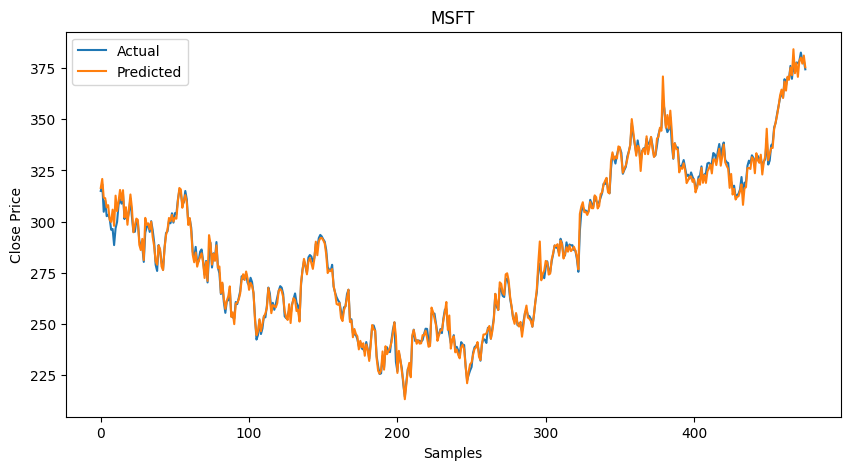

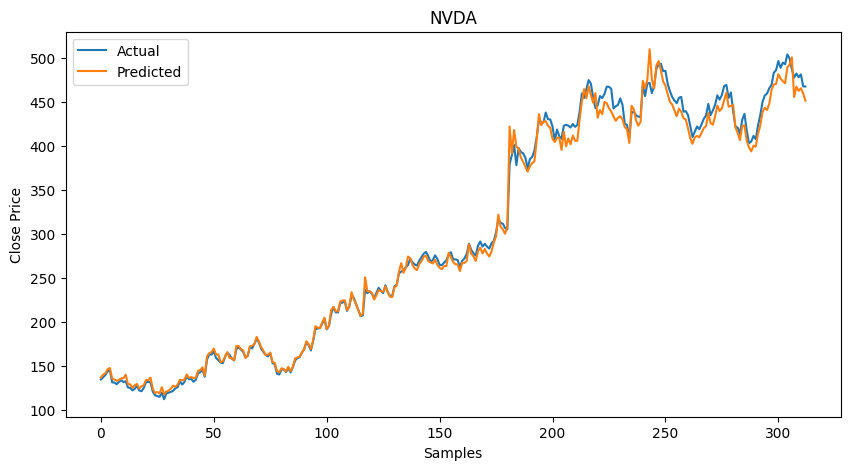

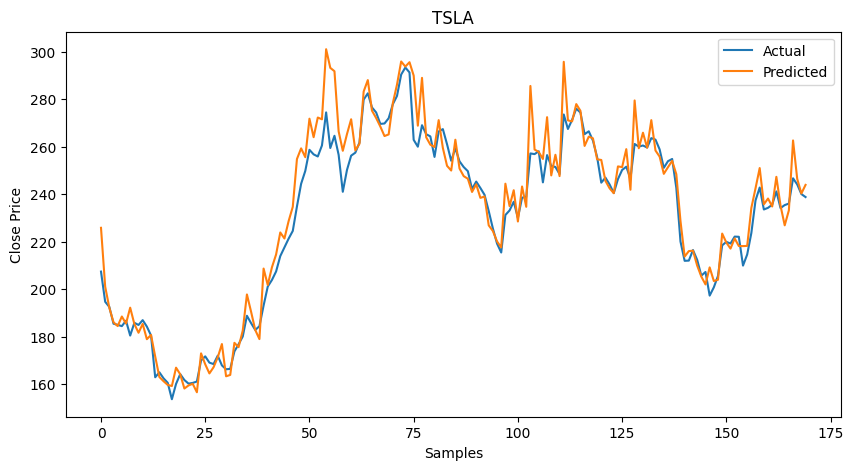

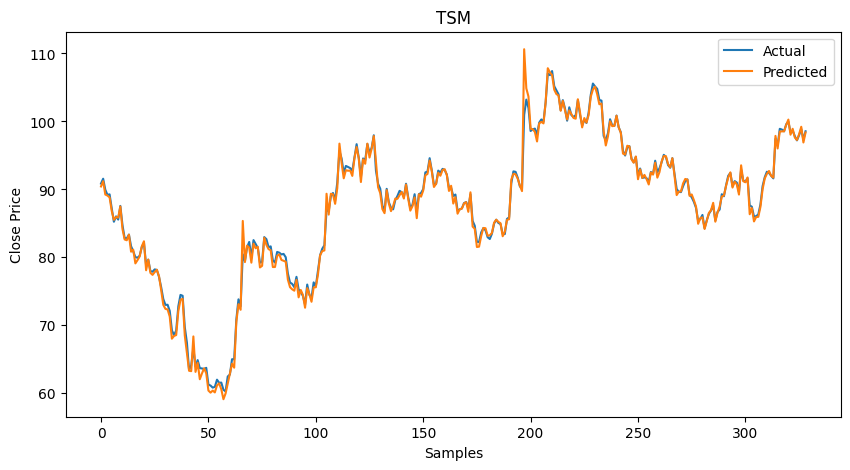

In [6]:
filenames = ['AAPL', 'AMSC', 'AMZN', 'GOOG', 'INTC', 'META', 'MSFT', 'NVDA', 'TSLA', 'TSM']
maes = []
rmses = []
r2s = []
for f in filenames:
    x,y,z = CNN_pred(f)
    maes.append(x)
    rmses.append(y)
    r2s.append(z)


In [7]:
print(np.array(maes).mean())
print(np.array(rmses).mean())
print(np.array([max(i,0) for i in r2s]).mean())

3.4665878
5.9284353
0.8430064768458181


Rubbish below

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [31]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Define the device as the first visible cuda device if available
device = torch.device("cuda:0" if cuda_available else "cpu")
device

device(type='cuda', index=0)

In [34]:
# Load the CSV data into a DataFrame
filename = 'AAPL'
df = pd.read_csv('data/'+filename+'.csv')

# Convert 'date' to datetime
df['trade_date'] = pd.to_datetime(df['trade_date'])

# Fill missing values
df.fillna(method='ffill', inplace=True)

# Select features and target
features = df[['open', 'high', 'low', 'change', 'pct_chg', 'vol', 'amount','pre_close']]
target = df['close']

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

# Create sequences
def create_sequences(input_data, target, look_back):
    sequences = []
    targets = []
    for i in range(len(input_data) - look_back):
        sequence = input_data[i:i + look_back]
        label = target[i + look_back]
        sequences.append(sequence)
        targets.append(label)
    return np.array(sequences), np.array(targets)

look_back = 10
X, y = create_sequences(scaled_features, scaled_target, look_back)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=False)

# Convert to PyTorch tensors and send them to the device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader for train set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


C:\Users\ChenJ\AppData\Local\Temp\ipykernel_16412\4223260616.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [35]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=64, kernel_size=2)
        self.fc1 = nn.Linear(64 * 6, 50)
        self.fc2 = nn.Linear(50, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = x.view(x.size(0), -1) # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [36]:
# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for sequences, labels in train_loader:
        # Move sequences and labels to device
        sequences, labels = sequences.to(device), labels.to(device)

        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x448 and 384x50)

In [ ]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy()  # Move predictions back to CPU
    true_values = y_test_tensor.cpu().numpy()  # Move true_values back to CPU

# Rescale values
predictions = scaler.inverse_transform(predictions)
true_values = scaler.inverse_transform(true_values)

# Calculate evaluation metrics
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))
r2 = r2_score(true_values, predictions)
print(f'MAE: {mae}, RMSE: {rmse}, R^2 Score: {r2}')

# Visualization of predictions and actual values for the test set
plt.figure(figsize=(15,5))
plt.plot(true_values, label='Actual Close Price')
plt.plot(predictions, label='Predicted Close Price')
plt.title('Stock Price Prediction on Test Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.savefig(filename+"_CNN.png")